# Application to Time series generation

Inspired by paper [“Utilizing Image Transforms and Diffusion Models for Generative Modeling of Short and Long Time Series”](https://arxiv.org/pdf/2410.19538) by Azencot et al., we can convert time series into images using invertible transforms and then use our diffusion model to sample new, realistic time series.

<div align="center">

<img src="figures/ts_gen.png" width="60%"/>

</div>

More precisely, we can generate a dataset of time series, for instance using an Ornstein-Uhlenbeck or GARCH process, then convert each time series of the dataset into its image representation using a transformation such as Delay Embedding or STFT. Finally we apply our ScoreNet to these images to generate new ones, and we finally use the inverse transformation to sample synthetic time series from the generated images.

To assess how close the generated trajectories are to the original ones, we can estimate the parameters of the underlying process via **maximum likelihood estimation** on the generated data, and compare them to the true parameters used to simulate the dataset.

## Imports, device, seed

In [1]:
# Libs externes
from utils.utils import *

# Libs internes
from models.score_net import ScoreNet
from models.loss import loss_VE, loss_VP
from models.sampling import euler_sampler_VE, euler_sampler_VP
from models.training import train_score_model
from utils.imports import *
from utils.data_generation import *
from utils.ts_to_img import *

In [2]:
# CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# Set the random seed for reproducibility
set_seed(0)

# Synthetic Ornstein Uhlenbeck dataset

The **Ornstein-Uhlenbeck** (OU) process is a mean-reverting stochastic process commonly used in physics and finance. It is the solution to the following stochastic differential equation (SDE):

$$
dX_t = \theta (\mu - X_t) dt + \sigma dW_t,
$$

where:
- $\theta > 0$ is the mean-reversion rate,
- $\mu$ is the long-term mean,
- $\sigma$ is the volatility parameter,
- $W_t$ is a standard Brownian motion.

The process tends to drift toward the mean $\mu$ over time, with randomness introduced by the Brownian noise. It’s a stationary, Gaussian, and Markovian process, often used to model interest rates, volatility, or other quantities that fluctuate around a long-term value. Let's generate an OU dataset:

In [4]:
# Model parameters

M_train = 10000
M_test = 1000

theta_range = [0.5, 2.5]
mu_range = [0.5, 1.5]
sigma_range = [0.1, 0.5]

N = 252
deltati = 1/252

In [5]:
X_OU_train = generate_OU_dataset(M_train, N, 
                                 theta_range,
                                 mu_range,
                                 sigma_range)

X_OU_test = generate_OU_dataset(M_test, N, 
                                 theta_range,
                                 mu_range,
                                 sigma_range)

In [6]:
X_OU_train.shape

(10000, 253)

In [7]:
X_OU_test.shape

(1000, 253)

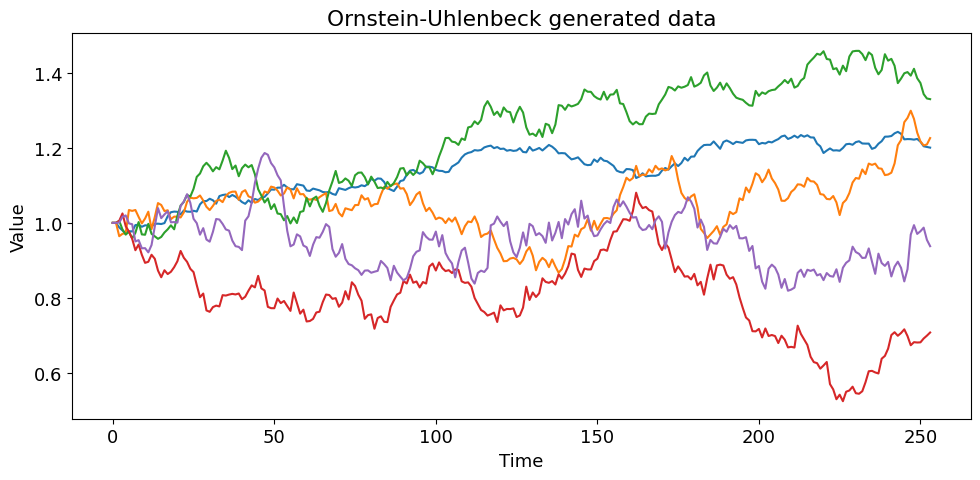

In [8]:
show_random_time_series(X_OU_test, x0=1, title="Ornstein-Uhlenbeck generated data", figsize=(10, 5), n_plot=5)

## Convert time series to image

**Delay embeddings** transform a univariate time series $x_{1:L} \in \mathbb{R}^L$ to an image by arranging the information of the series in columns and pad if needed. Let $m, n$ be two user parameters representing the skip value and the column dimension, respectively. We construct the following matrix $X$,

$$
X = 
\begin{bmatrix}
x_1 & x_{m+1} & \cdots & x_{L-n} \\
\vdots & \vdots & & \vdots \\
x_n & x_{n+m+1} & \cdots & x_L \\
\end{bmatrix}
\in \mathbb{R}^{n \times q},
$$

where $q = \lceil (L - n)/m \rceil$. The image $x_{\text{img}}$ is created by padding with zeros to fit the neural network input constraints. Given $x_{\text{img}}$, the original time series $x_{1:L}$ can be extracted in multiple ways. For instance, if $m = 1$, then $x_{1:L}$ is formed by concatenating the first row and last column of $x_{\text{img}}$. The delay embedding scales naturally to long sequences, e.g., setting $m = n = 256$ allows to encode 65k sequences with $256 \times 256$ images.

In [9]:
seq_len = X_OU_test.shape[1] # 252
delay = 8 # m dans le papier
embedding = 32 # n dans le papier

embedder = DelayEmbedder(device=device, seq_len=seq_len, delay=delay, embedding=embedding)
X_OU_test_tensor = torch.tensor(X_OU_test[:, :, None], dtype=torch.float32, device=device) # shape: (1000, 252, 1)
X_OU_test_imgs = embedder.ts_to_img(X_OU_test_tensor) # shape: (1000, 1, embedding, cols) padded to square

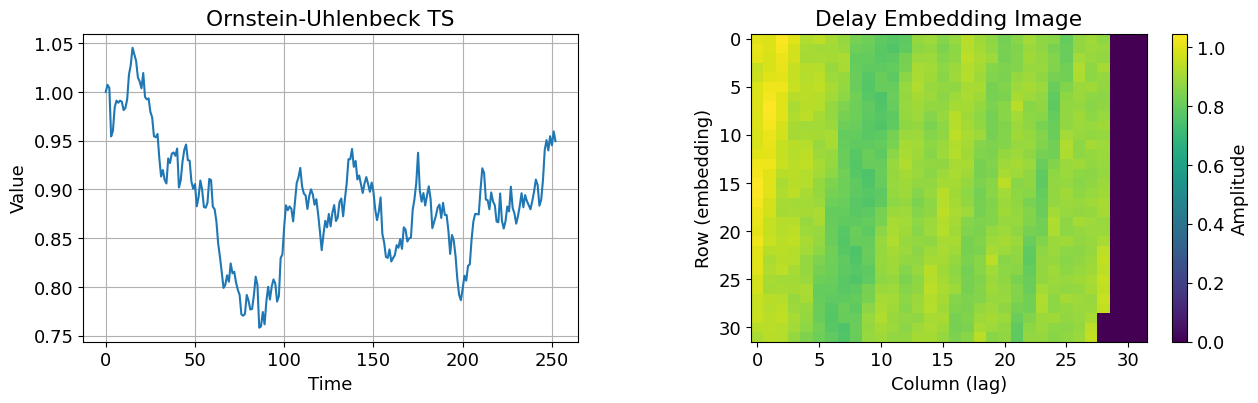

In [10]:
show_ts_and_embedding(X_OU_test_tensor[0], X_OU_test_imgs[0], title="Ornstein-Uhlenbeck TS")

**Interpretation**: In the image transform, each column represents a temporal window extracted from the original series, shifted in time by a fixed step (the *delay*), while each row corresponds to a relative position within that window (up to *embedding* points). The color values reflect the amplitude of the time series at each point.

The smooth transitions in color and the absence of abrupt changes indicate a slow and regular dynamic, which is characteristic of the OU process. A dark area is also visible on the right side of the image: this comes from the padding applied to the last column, necessary when the sliding window exceeds the length of the series. This type of representation makes the time series suitable for processing by convolutional models such as U-Net.

## Convert image to time series

In [11]:
X_OU_test_recon = embedder.img_to_ts(X_OU_test_imgs) # shape: (500, 252, 1)
X_OU_test_recon = X_OU_test_recon.squeeze(-1).cpu().numpy() # shape: (500, 252)$
error = np.abs(X_OU_test_recon - X_OU_test)
print("Erreur absolue moyenne :", np.mean(error))
print("Erreur max :", np.max(error))

Erreur absolue moyenne : 2.2248280477992436e-08
Erreur max : 5.9604347235620025e-08


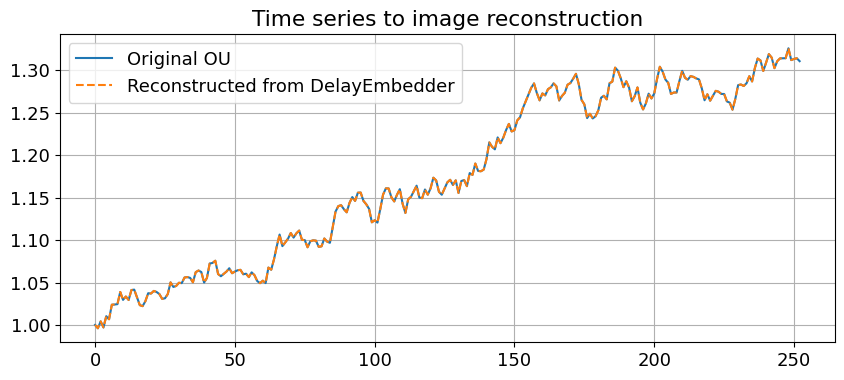

In [12]:
i = np.random.randint(0, M_test)
plt.figure(figsize=(10, 4))
plt.plot(X_OU_test[i], label='Original OU')
plt.plot(X_OU_test_recon[i], '--', label='Reconstructed from DelayEmbedder')
plt.title(f"Time series to image reconstruction")
plt.legend()
plt.grid(True)
plt.show()

# Training with diffusion model

In [13]:
# Hyperparameters
batch_size = 32
lr = 1e-4
n_epochs = 50

In [14]:
seq_len = X_OU_train.shape[1] # 252
delay = 8 # m dans le papier
embedding = 32 # n dans le papier

embedder = DelayEmbedder(device=device, seq_len=seq_len, delay=delay, embedding=embedding)

X_OU_train_tensor = torch.tensor(X_OU_train[:, :, None], dtype=torch.float32, device=device)  # (M, 252, 1)
X_OU_train_imgs = embedder.ts_to_img(X_OU_train_tensor)  # convert to images (M, 1, embedding, cols) padded to square
train_loader_OU = DataLoader(X_OU_train_imgs, batch_size=batch_size, shuffle=True)


X_OU_test_tensor = torch.tensor(X_OU_test[:, :, None], dtype=torch.float32, device=device)
X_OU_test_imgs = embedder.ts_to_img(X_OU_test_tensor)
test_loader_OU = DataLoader(X_OU_test_imgs, batch_size=batch_size, shuffle=True)

In [15]:
X_OU_train_imgs.shape

torch.Size([10000, 1, 32, 32])

In [16]:
X_OU_test_imgs.shape

torch.Size([1000, 1, 32, 32])

In [17]:
X_OU_train_imgs[0].shape

torch.Size([1, 32, 32])

### Diffusion using VE SDE

In [18]:
sigma = 25.0

# Diffusion: g(t)
def diffusion_VE(t):
    t = t.to(device)
    return sigma ** t

# Std of the perturbation kernel p_{0t}(x(t) | x(0))
def perturbation_kernel_std_VE(t):
    t = t.to(device)
    return torch.sqrt((sigma ** (2 * t) - 1.) / (2. * np.log(sigma)))

In [19]:
# Model and optimizer initialization for the OU process (VP)
score_model_OU_VE = ScoreNet(perturbation_kernel_std=perturbation_kernel_std_VE, padding=1) # padding=1 in order to use the model with images of size (1, 32, 32)
score_model_OU_VE = torch.nn.DataParallel(score_model_OU_VE).to(device)
optimizer_OU_VE = Adam(score_model_OU_VE.parameters(), lr=lr)
score_model_OU_VE.training

True

In [20]:
ckpt_path_OU_VE = 'checkpoints/ckpt_best_OU_VE.pth'

In [21]:
train_losses_OU_VE, val_losses_OU_VE = train_score_model(
    model=score_model_OU_VE,
    train_loader=train_loader_OU,
    test_loader=test_loader_OU,
    loss_fn=loss_VE,
    optimizer=optimizer_OU_VE,
    perturbation_kernel_std=perturbation_kernel_std_VE,
    device=device,
    ckpt_path=ckpt_path_OU_VE,
    n_epochs=50,
    patience=5
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: Train Loss = 868.4884, Val Loss = 271.4977


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: Train Loss = 186.1806, Val Loss = 134.2779


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: Train Loss = 106.1015, Val Loss = 87.3387


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: Train Loss = 74.0546, Val Loss = 63.8306


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: Train Loss = 57.4198, Val Loss = 53.4890


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: Train Loss = 45.7753, Val Loss = 42.6559


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: Train Loss = 38.0754, Val Loss = 34.6781


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: Train Loss = 32.9756, Val Loss = 29.5229


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: Train Loss = 28.5566, Val Loss = 26.6720


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: Train Loss = 25.5210, Val Loss = 25.4371


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: Train Loss = 23.1946, Val Loss = 21.8150


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: Train Loss = 21.0973, Val Loss = 22.2419


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: Train Loss = 19.7448, Val Loss = 18.5300


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: Train Loss = 18.2922, Val Loss = 17.0114


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: Train Loss = 17.5169, Val Loss = 15.9909


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: Train Loss = 16.3636, Val Loss = 16.6453


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: Train Loss = 15.3390, Val Loss = 15.7727


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: Train Loss = 14.6136, Val Loss = 13.9905


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: Train Loss = 14.8753, Val Loss = 14.4143


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: Train Loss = 13.3670, Val Loss = 12.1286


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: Train Loss = 13.4210, Val Loss = 12.4766


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: Train Loss = 13.0942, Val Loss = 14.9963


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: Train Loss = 12.2347, Val Loss = 12.6348


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: Train Loss = 11.7495, Val Loss = 11.9710


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: Train Loss = 12.1512, Val Loss = 12.0508


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: Train Loss = 11.6828, Val Loss = 11.6321


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: Train Loss = 12.0791, Val Loss = 11.7360


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: Train Loss = 11.2136, Val Loss = 11.9234


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 29: Train Loss = 11.1942, Val Loss = 10.0783


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 30: Train Loss = 10.4282, Val Loss = 9.9921


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 31: Train Loss = 10.6873, Val Loss = 11.4534


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 32: Train Loss = 10.2660, Val Loss = 11.2891


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 33: Train Loss = 10.1095, Val Loss = 9.3124


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 34: Train Loss = 10.4005, Val Loss = 9.2964


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 35: Train Loss = 9.6166, Val Loss = 9.1426


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 36: Train Loss = 9.7713, Val Loss = 9.6518


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 37: Train Loss = 10.6458, Val Loss = 9.9078


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 38: Train Loss = 10.1438, Val Loss = 8.7127


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 39: Train Loss = 9.8193, Val Loss = 8.7674


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 40: Train Loss = 9.9449, Val Loss = 11.0519


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 41: Train Loss = 9.3059, Val Loss = 9.0663


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 42: Train Loss = 9.8864, Val Loss = 9.6407


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 43: Train Loss = 9.5895, Val Loss = 9.1605
Early stopping at epoch 43


### Sampling VE SDE

In [22]:
# Loading weights
score_model_OU_VE_sample = ScoreNet(perturbation_kernel_std=perturbation_kernel_std_VE, padding=1)
score_model_OU_VE_sample = torch.nn.DataParallel(score_model_OU_VE_sample).to(device)
score_model_OU_VE_sample.load_state_dict(torch.load("checkpoints/ckpt_best_OU_VE.pth", map_location=device))

<All keys matched successfully>

In [23]:
samples_OU_VE = euler_sampler_VE(
    score_model=score_model_OU_VE_sample,
    perturbation_kernel_std=perturbation_kernel_std_VE,
    diffusion_coeff=diffusion_VE,
    batch_size=500,
    num_steps=500,
    device=device,
    input_size=(1, 32, 32)
)

  0%|          | 0/500 [00:00<?, ?it/s]

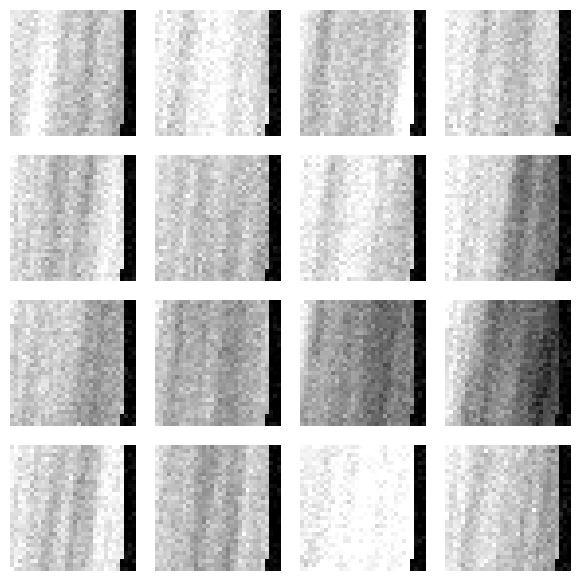

In [24]:
show_image_grid(samples_OU_VE)

In [25]:
TS_samples_OU_VE = embedder.img_to_ts(samples_OU_VE)   # shape: (16, 252, 1)
TS_samples_OU_VE = TS_samples_OU_VE.squeeze(-1).cpu().numpy()  # shape: (16, 252)
TS_samples_OU_VE.shape

(500, 253)

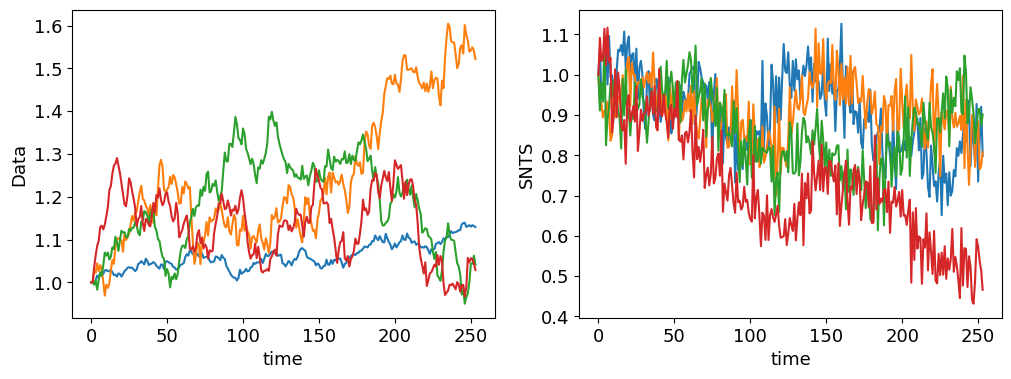

In [26]:
show_real_vs_sampled_ts(X_OU_train, TS_samples_OU_VE, 1)

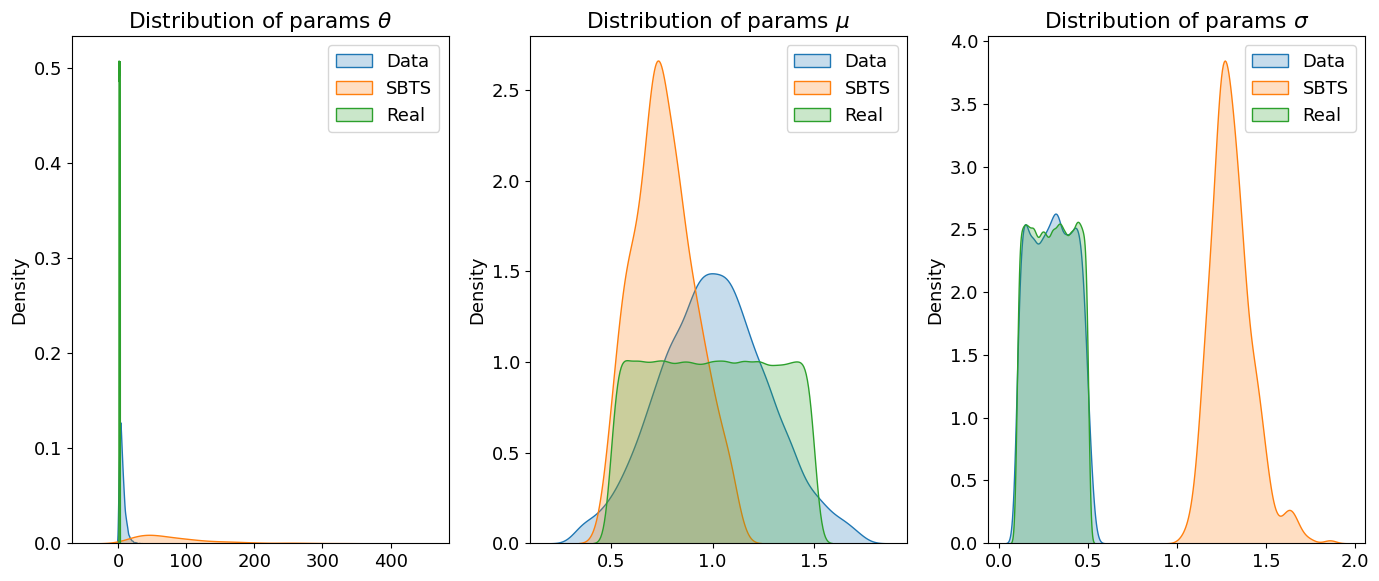

In [27]:
show_params_distrib_OU(X_OU_train, TS_samples_OU_VE, dt=deltati)

### Diffusion using VP SDE

In [28]:
sigma = np.sqrt(2.0)

# Drift : f(x, t)
def drift_VP(x, t):
    return -x

# Diffusion : g(t)
def diffusion_VP(t):
    return torch.full_like(t, sigma)

# Std of the perturbation kernel p_{0t}(x(t) | x(0))
def perturbation_kernel_std_VP(t):
    return torch.sqrt(1. - torch.exp(-2. * t)).to(device)

In [29]:
# Model and optimizer initialization for the OU process (VP)
score_model_OU_VP = ScoreNet(perturbation_kernel_std=perturbation_kernel_std_VP, padding=1) # padding=1 in order to use the model with images of size (1, 32, 32)
score_model_OU_VP = torch.nn.DataParallel(score_model_OU_VP).to(device)
optimizer_OU_VP = Adam(score_model_OU_VP.parameters(), lr=lr)
score_model_OU_VP.training

True

In [30]:
ckpt_path_OU_VP = 'checkpoints/ckpt_best_OU_VP.pth'

In [31]:
train_losses, val_losses = train_score_model(
    model=score_model_OU_VP,
    train_loader=train_loader_OU,
    test_loader=test_loader_OU,
    loss_fn=loss_VP,
    optimizer=optimizer_OU_VP,
    perturbation_kernel_std=perturbation_kernel_std_VP,
    device=device,
    ckpt_path=ckpt_path_OU_VP,
    n_epochs=50,
    patience=5
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: Train Loss = 738.5033, Val Loss = 196.7320


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: Train Loss = 132.7592, Val Loss = 86.8680


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: Train Loss = 70.4865, Val Loss = 56.2202


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: Train Loss = 45.7047, Val Loss = 36.8953


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: Train Loss = 33.5082, Val Loss = 31.1442


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: Train Loss = 28.0186, Val Loss = 24.9405


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: Train Loss = 22.4157, Val Loss = 22.2704


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: Train Loss = 20.1492, Val Loss = 17.9088


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: Train Loss = 17.6451, Val Loss = 16.1449


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: Train Loss = 16.5019, Val Loss = 14.1460


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 11: Train Loss = 14.8954, Val Loss = 15.3632


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 12: Train Loss = 13.2556, Val Loss = 13.0776


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 13: Train Loss = 12.8724, Val Loss = 13.1768


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 14: Train Loss = 11.7542, Val Loss = 13.1465


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: Train Loss = 11.7434, Val Loss = 11.3417


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 16: Train Loss = 12.1355, Val Loss = 11.9524


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 17: Train Loss = 10.1929, Val Loss = 10.3257


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 18: Train Loss = 10.8201, Val Loss = 10.6533


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 19: Train Loss = 10.1186, Val Loss = 9.7247


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: Train Loss = 10.5044, Val Loss = 9.9942


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 21: Train Loss = 10.0199, Val Loss = 9.2523


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 22: Train Loss = 9.5423, Val Loss = 9.5110


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 23: Train Loss = 9.6562, Val Loss = 9.1187


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 24: Train Loss = 9.3191, Val Loss = 9.1849


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: Train Loss = 9.0356, Val Loss = 9.8249


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 26: Train Loss = 8.6647, Val Loss = 10.1784


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 27: Train Loss = 8.9675, Val Loss = 9.9653


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 28: Train Loss = 9.2210, Val Loss = 9.8205
Early stopping at epoch 28


### Sampling VP SDE

In [32]:
# Loading weights
score_model_OU_VP_sample = ScoreNet(perturbation_kernel_std=perturbation_kernel_std_VP, padding=1)
score_model_OU_VP_sample = torch.nn.DataParallel(score_model_OU_VP_sample).to(device)
score_model_OU_VP_sample.load_state_dict(torch.load("checkpoints/ckpt_best_OU_VP.pth", map_location=device))

<All keys matched successfully>

In [33]:
samples_OU_VP = euler_sampler_VP(
    score_model=score_model_OU_VP_sample,
    diffusion_coeff=diffusion_VP,
    batch_size=500,
    num_steps=500,
    device=device,
    input_size=(1, 32, 32)
)

  0%|          | 0/500 [00:00<?, ?it/s]

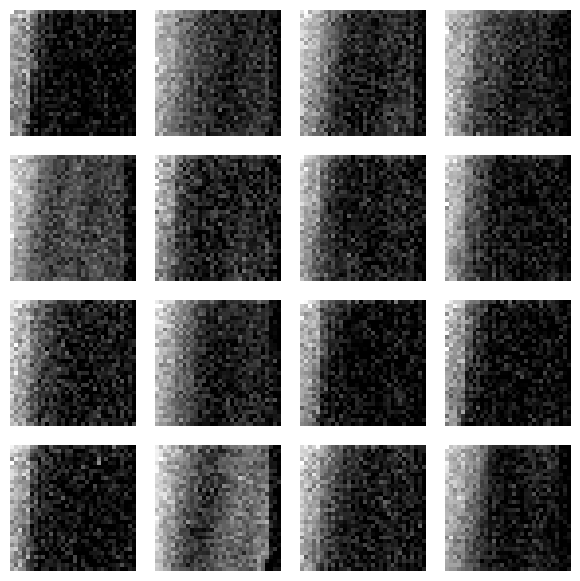

In [34]:
show_image_grid(samples_OU_VP)

In [35]:
TS_samples_OU_VP = embedder.img_to_ts(samples_OU_VP)   # shape: (16, 252, 1)
TS_samples_OU_VP = TS_samples_OU_VP.squeeze(-1).cpu().numpy()  # shape: (16, 252)
TS_samples_OU_VP.shape

(500, 253)

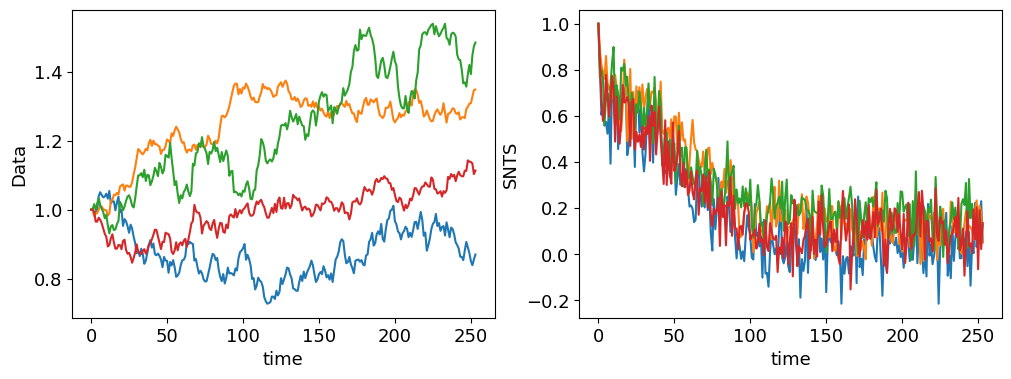

In [36]:
show_real_vs_sampled_ts(X_OU_train, TS_samples_OU_VP, 1)

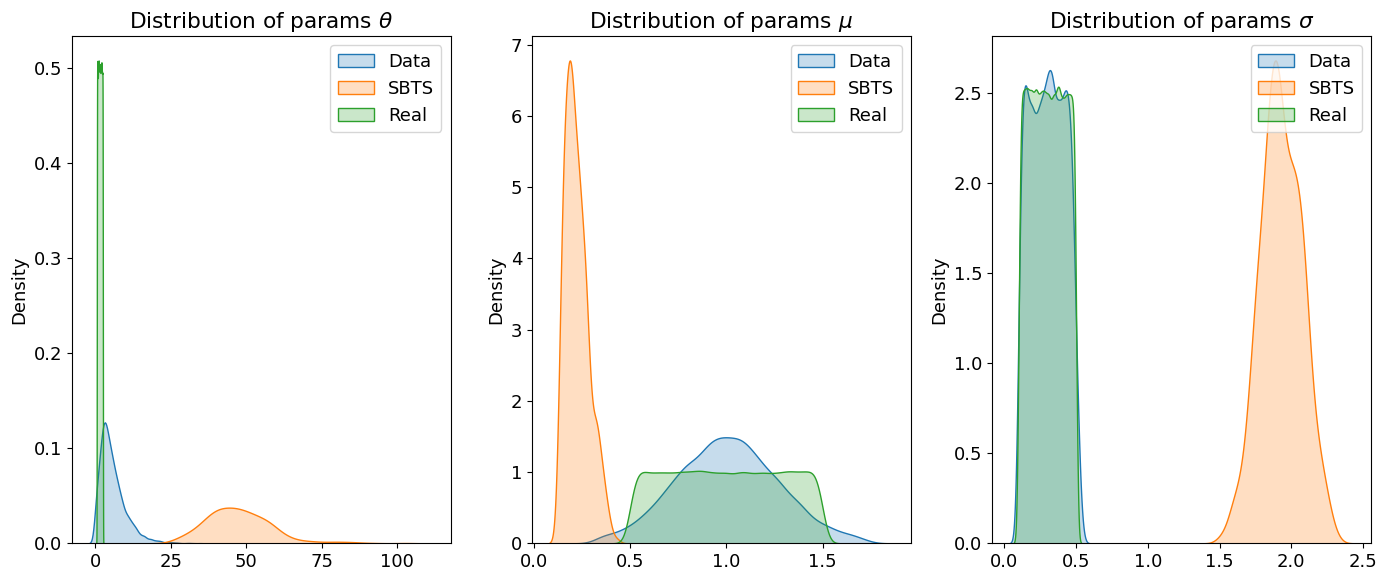

In [37]:
show_params_distrib_OU(X_OU_train, TS_samples_OU_VP, dt=deltati)